![title](../NAG_logo.png)
#  Noisy Nonlinear Programming exersize

For this exersize you will experiment with functions that exhibit systemic noise and how classical optimization methods compare with DFO solvers. The main idea is to repeatedly solve the problem for an increasing amount of noise level (increasing the variance of the generated white noise) and observe how a classical method (say, FOAS) compares with a DFO (say, `handle_solve_dfno`, see documentation) solver.

 * Modify the notebook so `handle_solve_bounds_foas` solves the problem using finite-differences to approximate the gradient of the objective function, so just provide and **empty** `objgrd` that returns `inform = 0`. Tip: see documentation how to request the solver to estimate the derivatives.
 
 * Run this notebook for a variety of noise levels, record your findings in a table similar to
 
 
 | Solver | Noise level (var, $\sigma^2$)       | Solution quality, or other metric |
 |--------|------------------------|------------|
 |`handle_solve_bouns_foas`        | $0.0$      |
 &nbsp;                            | $10^{-12}$ |
 &nbsp;                            | $10^{-11}$ |
 &nbsp;                            | $10^{-10}$ |
 &nbsp;                            | $10^{-9}$  |
 &nbsp;                            | $10^{-8}$  |
 &nbsp;                            | $10^{-7}$  |
 &nbsp;                            | $10^{-6}$  |
 |`handle_solve_dfno`              | $0.0$      |
 &nbsp;                            | $10^{-12}$ |
 &nbsp;                            | $10^{-11}$ |
 &nbsp;                            | $10^{-10}$ |
 &nbsp;                            | $10^{-9}$  |
 &nbsp;                            | $10^{-8}$  |
 &nbsp;                            | $10^{-7}$  |
 &nbsp;                            | $10^{-6}$  |
 
 
 * Substitute FOAS solver for a DFO solver and repear the experiment, record your findings in the previous table.
  
 * Describe your findings

### Installing the NAG library and running this notebook

This notebook depends on the NAG library for Python to run. Please read the instructions in the [Readme.md](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#install) file to download, install and obtain a licence for the library.

Instruction on how to run the notebook can be found [here](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#jupyter).

# Rosenbrock function: Bound constrained optimization
First order active set bound-constrained nonlinear programming

2d Rosenbrock example: This notebook illustrates the usage of FOAS to solve the bound-constrained 2d Rosenbrock function. It produces a plot showing the steps taken by the solver to find the solution point.

In [1]:
from naginterfaces.base import utils
from naginterfaces.library import opt
from naginterfaces.library import rand

In [2]:
# Create a state structure for a repeatable sequence,
# using the NAG basic generator (genid=1):
statecomm = rand.init_repeat(genid=1, subid=1, seed=[1762543])
xmu = 0.0
n = 1

In [3]:
# Specify the noise level using as proxy the variance
#var = 1.0e-5
#var = 1.0e-6
#var = 1.0e-7
#var = 1.0e-8
#var = 1.0e-9
#var = 1.0e-10
#var = 1.0e-11
#var = 1.0e-12
var = 0.0

Add objective function, gradient and monitoring callback

In [15]:
def objfun(x, inform): 
    noise = rand.dist_normal(n, xmu, var, statecomm)[0]
    return ((1. - x[0])**2 + 100.*(x[1] - x[0]**2)**2 + noise, inform)

def objgrd(x, fdx, inform):
    """ No objective's gradient provided """
    inform = 0
    return inform


steps = []
def monit(x, rinfo, _stats, _data=None):
    """The monitor function."""
    steps.append([x[0], x[1], rinfo[0]])


Specify initial guess and do not change during the experimentation

In [6]:
x = [-0.8, -0.0]

Define the nonlinear objective (add to handle)

In [7]:
nvar = len(x)
handle = opt.handle_init(nvar)
opt.handle_set_nlnobj(handle, idxfd=list(range(1, nvar+1)))

Add the box bounds on the variable x to the handle

In [8]:
bl = [-1.0, -2.]
bu = [ 1.1,  2.]
opt.handle_set_simplebounds(
    handle,
    bl=bl,
    bu=bu,
)

Set some algorithmic options

In [13]:
for option in [
    'FOAS Print Frequency = 1',
    'Print Solution = yes',
    'FOAS Monitor Frequency = 1',
    'Print Level = 2',
    'Monitoring Level = 1',
    'FOAS Estimate Derivatives = Yes',
]:
    opt.handle_opt_set(handle, option)

Use an explicit I/O manager for abbreviated iteration output

In [10]:
iom = utils.FileObjManager(locus_in_output=False)

Solve the problem

In [16]:
try:
    ret = opt.handle_solve_bounds_foas(handle, x, objfun=objfun, objgrd=objgrd, monit=monit, io_manager=iom)
except utils.NagValueError as e:
    if e.errno == 21:
        # Error 21 indicates starting point x0 was unusable in either objfun or objgrd...
        print('\nSeems you have not requested to use finite-differences, or the starting point is unusable!\n{}'.format(e.msg))
    else:
        print('Problem could not be solved! Reason:\n{}'.format(e.msg))


 ----------------------------------------------------------
  E04KF, First order method for bound-constrained problems
 ----------------------------------------------------------

 Begin of Options
     Print File                    =                   9     * d
     Print Level                   =                   2     * U
     Print Options                 =                 Yes     * d
     Print Solution                =                 All     * U
     Monitoring File               =                  -1     * d
     Monitoring Level              =                   1     * U
     Foas Monitor Frequency        =                   1     * U
     Foas Print Frequency          =                   1     * U

     Infinite Bound Size           =         1.00000E+20     * d
     Task                          =            Minimize     * d
     Stats Time                    =                  No     * d
     Time Limit                    =         1.00000E+06     * d
     Verify Derivati

In [17]:
steps.append([ret.x[0], ret.x[1], ret.rinfo[0]]) # Add last step
import numpy as np

Destroy the handle

In [18]:
opt.handle_free(handle)

Evaluate the funtion over the domain

In [19]:
x_m = np.linspace(bl[0]-0.5, bu[0]+0.5, 101)
y_m = np.linspace(bl[1]-0.5, bu[1]+0.5, 101)
z_m = np.empty((101, 101))
j = y_m[0]
for i in range(0, 101):
    for j in range(0, 101):
        z_m[i, j], _inform = objfun([x_m[i], y_m[j]], 1)
nb = 25
x_box = np.linspace(bl[0], bu[0], nb)
y_box = np.linspace(bl[1], bu[1], nb)
box = np.array([np.concatenate([x_box, bu[0]*np.ones(nb), x_box[::-1], bl[0]*np.ones(nb)]),
      np.concatenate([bl[1]*np.ones(nb), y_box, bu[1]*np.ones(nb), y_box[::-1]])])
z_box = np.empty(box[0].shape)
for i in range(0, (box[0].size)):
    z_box[i], _inform = objfun([box[0][i], box[1][i]], 1)

X, Y = np.meshgrid(x_m, y_m, indexing='ij')

Plot function and steps taken

In [20]:
# Select the display backend for Jupyter:
%matplotlib nbagg
steps = np.column_stack(steps)

<IPython.core.display.Javascript object>


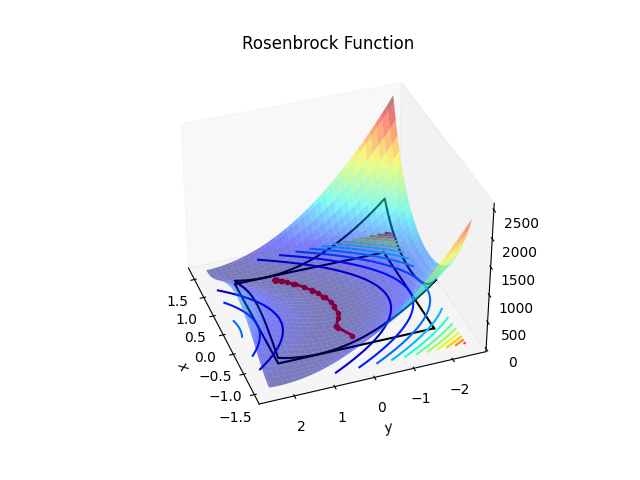

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm
ax = plt.figure().add_subplot(projection='3d')
ax.grid(False)
ax.plot(box[0], box[1], z_box, 'k-', linewidth=1.5)
ax.plot([bl[0], bu[0], bu[0], bl[0], bl[0]], [bl[1], bl[1], bu[1], bu[1], bl[1]], -1.2*np.ones(5), 'k-')
ax.contour(X, Y, z_m, 15, offset=-1.2, cmap=cm.jet)
ax.plot_surface(X, Y, z_m, cmap=cm.jet, alpha=0.5)
ax.set_title('Rosenbrock Function')
ax.set_xlabel(r'$\mathit{x}$')
ax.set_ylabel(r'$\mathit{y}$')
ax.plot(steps[0], steps[1], steps[2], 'o-', color='red', markersize=3, linewidth=2)
ax.azim = 160
ax.elev = 35
plt.show()

# Obtaining the NAG Library for Python

The [NAG Library for Python](https://www.nag.com/content/nag-library-python) is commercially licensed software but this notebook is licensed under the [BSD 3-Clause License](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/LICENSE)
* [Click here](https://github.com/numericalalgorithmsgroup/NAGPythonExamples#nag-library-for-python-installation) for NAG Library for Python installation details
* [Click here](https://github.com/numericalalgorithmsgroup/NAGPythonExamples#obtaining-a-license) for details on how to obtain a license for the NAG Library for Python